# Similarity Label

This is where I developed the idea of the similarity label. This notebook contains the analysis on what each similarity label represents. My idea was that if a group of dwellings are likely to be in the same block cluster if they have similar sequence values. Here are some points to keep in mind:

* The functions are outdated so this not to be run
* I set the number of label to 20 and the analysis is based on that. More labels is not unreasonable when the idea is to capture the similarity of sequence combinations among dwellings. 
* This is not presented in this notebook, but with more number of labels, I observed some labels without dwellings at all. It is because the label only contain   

One issue I have in mind but have not have time to discussed/think though is that the label uses a clustering approach on the training data so there are some cases when the approach can't be applied to the test data. 


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer


In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [3]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [4]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

## Incooperate Enumerator sequence

In [5]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [6]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

In [7]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [8]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                     n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


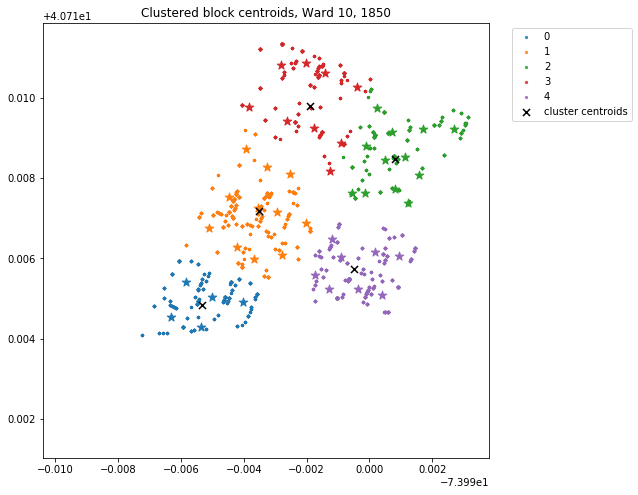

In [9]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [10]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6666666666666666, 0.5221169036334913, 0.6463844797178131, 0.5586734693877551, 0.5772425249169435, 0.5117289313640313, 0.44905956112852663, 0.6262798634812287, 0.520096463022508, 0.47966231772831924]
avg Test score: 0.5557911181047284


#### rerun the prev model on entire dataset

In [11]:
init_pred = interpolate_sequences.model.predict(interpolate_sequences.last_te[interpolate_sequences.feature_names])

### Create similarity measurement [only sequences]

In [12]:
similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
print(len(similar_cols))

4


In [13]:
## take only columns to be clustered
## unknown values are treated as a new category
similarity_df = interpolate_sequences.df[similar_cols].copy()
similarity_df.fillna(value=-1, inplace=True)

In [14]:
## process data fro Kmodes. Convert all columns into string
for c in similarity_df.columns:
    similarity_df[c] = similarity_df[c].astype('str')

#### run k modes

In [15]:
K = 20

km_cao = KModes(n_clusters=K, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(similarity_df, categorical=[i for i in range(1,len(similar_cols))])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 11174.0


#### see how block clusters are distributioned in each similarity cluster

* x axis = block cluster
* y axis = counts

In [16]:
k_modes_result = interpolate_sequences.df.copy()
k_modes_result['kmodes'] = fitClusters_cao

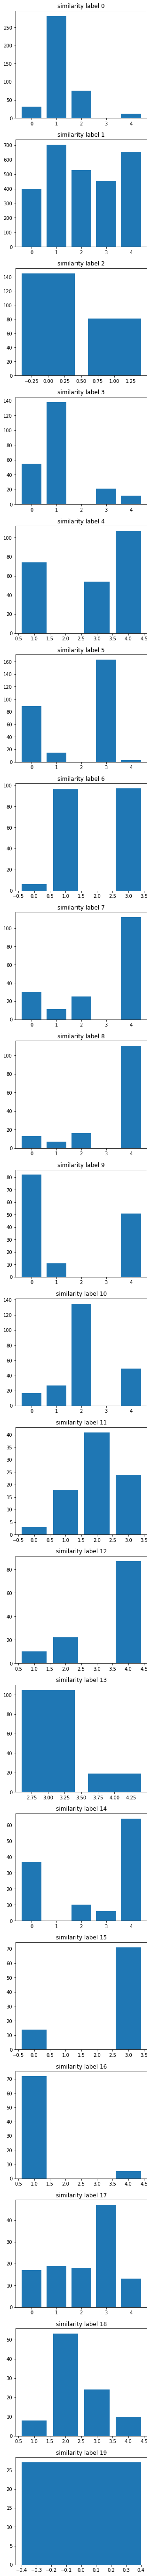

In [31]:
fig, ax = plt.subplots(K,1, figsize = (5, 100))
for k in range(K):
    temp = k_modes_result[['block_num', 'cluster', 'kmodes']]
    temp = temp.loc[temp['kmodes'] == k]['cluster'].value_counts()
    temp.sort_index(inplace=True)
    ax[k].bar(temp.index, temp.values)
    ax[k].set_title('similarity label ' +str(k))
    

There are some similarity clusters that represent some block cluster well.
* 6 >> 0 or 3
* 8 >> 4
* 12 >> 4
* 13 >> 0
* 15 >> 0
* 16 >> 3
* 18 >> 2
* 19 >> 1

#### train a predicting model that uses the similarity measure as a categorical varaible. **Not target encoded

In [18]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                     n_estimators = 50))])

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [20]:
transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['kmodes'])])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

In [21]:
## Change some global info 

interpolate_sequences.df = k_modes_result
interpolate_sequences.feature_names = all_cols + ['kmodes']
interpolate_sequences.model = pipeline

In [22]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 0.979486644053466
Test score: [0.6649305555555556, 0.6169036334913112, 0.6111111111111112, 0.5297619047619048, 0.6602990033222591, 0.6020851433536055, 0.5219435736677116, 0.6237201365187713, 0.5731511254019293, 0.5295471987720645]
avg Test score: 0.5933453385956224


### The cross validation score improves from 0.54 (see above) to 0.59 when the similarity score is included

## Inspect records and their similarity cluster

In [23]:
k_modes_result_w_pred = interpolate_sequences.last_te.copy()
k_modes_result_w_pred['pred_cluster'] = interpolate_sequences.model.predict(k_modes_result_w_pred[interpolate_sequences.feature_names])
k_modes_result_w_pred['prev_pred_cluster'] = init_pred
k_modes_result_w_pred['cluster'] = interpolate_sequences.last_te_y

In [24]:
k_modes_result_w_pred.head()

,CENSUS_SERIALB,CENSUS_AGE,CENSUS_PAGENUM,CENSUS_SEXB,CENSUS_RACEB,sequence_id,CENSUS_DWELLING_SIZE,CENSUS_SEQ_NUM,CENSUS_LABFORCE,CENSUS_LINE,...,sequence_order_enum,CENSUS_DWELLING_SEQ,dwelling_seq_id,fixed_seq,enum_dist_id,enum_dist_order,kmodes,pred_cluster,prev_pred_cluster,cluster
607,2086027,39,200,1,120,74.0,4,1,2,200,...,5.0,133.0,0.0,1,69,3.0,1,4,4,4
608,2086027,38,200,2,120,74.0,4,2,0,200,...,5.0,133.0,0.0,1,69,3.0,1,4,4,4
609,2086027,17,200,1,120,74.0,4,3,2,200,...,5.0,133.0,0.0,1,69,3.0,1,4,4,4
610,2086027,28,200,2,120,74.0,4,4,0,200,...,5.0,133.0,0.0,1,69,3.0,1,4,4,4
631,2086030,25,210,2,120,74.0,6,1,0,20,...,5.0,136.0,0.0,1,69,3.0,1,4,4,4


#### Seq similarity is able to capture the break (label 2)

In [34]:

k_modes_result_w_pred.loc[k_modes_result_w_pred['kmodes'] == 2][['sequence_id', "dwelling_seq_id", 
                                                                 "fixed_seq", "enum_dist_id",
                                                                 'kmodes', 'pred_cluster', 'prev_pred_cluster', 'cluster']]

,sequence_id,dwelling_seq_id,fixed_seq,enum_dist_id,kmodes,pred_cluster,prev_pred_cluster,cluster
14629,1290.0,1043.0,31,1290,2,0,1,0
14630,1290.0,1043.0,31,1290,2,0,1,0
14631,1290.0,1043.0,31,1290,2,0,1,0
14632,1290.0,1043.0,31,1290,2,0,1,0
14633,1290.0,1043.0,31,1290,2,0,1,0
14634,1290.0,1043.0,31,1290,2,0,1,0
14635,1290.0,1043.0,31,1290,2,0,1,0
14636,1290.0,1043.0,31,1290,2,0,1,0
14637,1290.0,1043.0,31,1290,2,0,1,0
14784,1290.0,1043.0,31,1290,2,0,1,0


#### Sometimes it is biased towarda the majority of clusters in the training set

In [35]:

k_modes_result_w_pred.loc[k_modes_result_w_pred['kmodes'] == 15][['sequence_id', "dwelling_seq_id", 
                                                                 "fixed_seq", "enum_dist_id",
                                                                 'kmodes', 'pred_cluster', 'prev_pred_cluster', 'cluster']]

,sequence_id,dwelling_seq_id,fixed_seq,enum_dist_id,kmodes,pred_cluster,prev_pred_cluster,cluster
15759,1353.0,1043.0,33,1353,15,3,2,0
15760,1353.0,1043.0,33,1353,15,3,2,0
15761,1353.0,1043.0,33,1353,15,3,2,0
15762,1353.0,1043.0,33,1353,15,3,2,0
15763,1353.0,1043.0,33,1353,15,3,2,0
15764,1353.0,1043.0,33,1353,15,3,2,0
15765,1353.0,1043.0,33,1353,15,3,2,0
15766,1353.0,1043.0,33,1353,15,3,2,0
15767,1353.0,1043.0,33,1353,15,3,2,0
15768,1353.0,1043.0,33,1353,15,3,2,0


In [25]:
k_modes_result_w_pred.shape

(1303, 25)

In [26]:
selected_cols = ['CD_ADDRESS', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'dwelling_seq_id', 
                 'fixed_seq', 'enum_dist_id', 'enum_dist_order', 'sequence_id', 'block_num', 
                 'cluster', 'kmodes', 'pred_cluster']

In [36]:
# for k in range(K):
#     temp = k_modes_result_w_pred.loc[k_modes_result['kmodes'] == k]
#     print('{}: {}'.format(k, np.sum(temp['pred_cluster'] != temp['prev_pred_cluster'])))

### Performance comparison

* prev model is the previous best model (use enumerator_dist, dwelling, fixed, distance + census features)
* current model is prev model with sequence similarity label (category)

When the predictions between the two models do not agree, the current one's prediction is more accurate.

In [38]:
# k = 0
for k in range(K):
    kmodes1 = k_modes_result_w_pred.loc[(k_modes_result_w_pred['kmodes'] == k) &
                                       (k_modes_result_w_pred['pred_cluster'] != k_modes_result_w_pred['prev_pred_cluster'])]
    print('\n\n similarity label:', k)
    print('total: ', k_modes_result_w_pred.loc[(k_modes_result_w_pred['kmodes'] == k)].shape[0])
    print('total unmatch: ', kmodes1.shape[0])
    print('prev correct:', kmodes1.loc[kmodes1['prev_pred_cluster'] == kmodes1['cluster']].shape[0])
    print('current correct:', kmodes1.loc[kmodes1['pred_cluster'] == kmodes1['cluster']].shape[0])



 similarity label: 0
total:  72
total unmatch:  54
prev correct: 19
current correct: 0


 similarity label: 1
total:  585
total unmatch:  170
prev correct: 60
current correct: 78


 similarity label: 2
total:  32
total unmatch:  17
prev correct: 0
current correct: 17


 similarity label: 3
total:  42
total unmatch:  13
prev correct: 0
current correct: 0


 similarity label: 4
total:  79
total unmatch:  44
prev correct: 0
current correct: 38


 similarity label: 5
total:  160
total unmatch:  39
prev correct: 0
current correct: 8


 similarity label: 6
total:  69
total unmatch:  11
prev correct: 0
current correct: 11


 similarity label: 7
total:  19
total unmatch:  13
prev correct: 13
current correct: 0


 similarity label: 8
total:  9
total unmatch:  9
prev correct: 0
current correct: 5


 similarity label: 9
total:  0
total unmatch:  0
prev correct: 0
current correct: 0


 similarity label: 10
total:  50
total unmatch:  0
prev correct: 0
current correct: 0


 similarity label: 11
to

In [30]:
k_modes_result_w_pred['pred_cluster']

607      4
608      4
609      4
610      4
631      4
        ..
22396    4
22397    2
22398    2
22399    2
22400    2
Name: pred_cluster, Length: 1303, dtype: int64